In [4]:
import os
import torch
import skimage
import scipy.io
import scipy.signal
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import stats
from einops import reduce, rearrange, repeat
from npeet import entropy_estimators as ee
from torch.optim.lr_scheduler import StepLR
from scipy.fft import rfft, rfftfreq, ifft
from einops import rearrange
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from Electrodes import Electrodes
from tqdm import tqdm

In [6]:
def calculate_de(window):
    return ee.entropy(window.reshape(-1,1), k=2)
# Input: Video with shape (32,7680)
# Output: Graph node features with shape (5*32, 59) -> 5 graphs with 32 nodes each with 59 features each
def process_video(video, feature='psd'):
#     print(video.shape)
    assert feature in ['psd', 'de']
    # Transform to frequency domain
    fft_vals = np.fft.rfft(video, axis=-1)
     # Get frequencies for amplitudes in Hz
    samplingFrequency = 128
    fft_freq = np.fft.rfftfreq(video.shape[-1], 1.0/samplingFrequency)
    # Delta, Theta, Alpha, Beta, Gamma
    bands = [(0,4),(4,8),(8,12),(12,30),(30,45)]
    
    band_mask = np.array([np.logical_or(fft_freq < f, fft_freq > t) for f,t in bands])
    band_mask = repeat(band_mask,'a b -> a c b', c=32)
    band_data = np.array(fft_vals)
    band_data = repeat(band_data,'a b -> c a b', c=5)
     
    band_data[band_mask] = 0
    
    band_data = np.fft.irfft(band_data)

    windows = skimage.util.view_as_windows(band_data, (5,32,128), step=128).squeeze()
    # (5, 32, 60, 128)
    windows = rearrange(windows, 'a b c d -> b c a d')
    
    if feature == 'psd':
        features = scipy.signal.periodogram(windows)[1]
        features = np.mean(features, axis=-1)
    if feature == 'de':
        features = np.apply_along_axis(calculate_de, -1, windows)

    
    features = rearrange(features, 'a b c -> (a b) c')
    features = torch.FloatTensor(features)

    return features

In [9]:
class DEAPDatasetEEGFeatures(InMemoryDataset):
  def __init__(self, root, raw_dir, processed_dir, feature='de', transform=None, pre_transform=None,include_edge_attr = True, undirected_graphs = True, add_global_connections=True, participant_from=1, participant_to=32, n_videos=40):
      self._raw_dir = raw_dir
      self._processed_dir = processed_dir
      self.participant_from = participant_from
      self.participant_to = participant_to
      self.n_videos = n_videos
      self.feature = feature
      # Whether or not to include edge_attr in the dataset
      self.include_edge_attr = include_edge_attr
      # If true there will be 1024 links as opposed to 528
      self.undirected_graphs = undirected_graphs
      # Instantiate class to handle electrode positions
      print('Using global connections' if add_global_connections else 'Not using global connections')
      self.electrodes = Electrodes(add_global_connections, expand_3d = False)
      super(DEAPDatasetEEGFeatures, self).__init__(root, transform, pre_transform)
      self.data, self.slices = torch.load(self.processed_paths[0])
      
  @property
  def raw_dir(self):
      return f'{self.root}/{self._raw_dir}'

  @property
  def processed_dir(self):
      return f'{self.root}/{self._processed_dir}'

  @property
  def raw_file_names(self):
      raw_names = [f for f in os.listdir(self.raw_dir)]
      raw_names.sort()
      return raw_names

  @property
  def processed_file_names(self):
      if not os.path.exists(self.processed_dir):
        os.makedirs(self.processed_dir)
      file_name = f'{self.participant_from}-{self.participant_to}' if self.participant_from is not self.participant_to else f'{self.participant_from}'
      return [f'deap_processed_graph.{file_name}_{self.feature}.dataset']

  def process(self):
        # Number of nodes per graph
        n_nodes = len(self.electrodes.positions_3d)

        if self.undirected_graphs:
            source_nodes, target_nodes = np.repeat(np.arange(0,n_nodes),n_nodes), np.tile(np.arange(0,n_nodes),n_nodes)
        else:
            source_nodes, target_nodes = np.tril_indices(n_nodes,n_nodes)
        
        edge_attr = self.electrodes.adjacency_matrix[source_nodes,target_nodes]
        
        # Remove zero weight links
        mask = np.ma.masked_not_equal(edge_attr, 0).mask
        edge_attr,source_nodes,target_nodes = edge_attr[mask], source_nodes[mask], target_nodes[mask]

        edge_attr, edge_index = torch.FloatTensor(edge_attr), torch.tensor([source_nodes,target_nodes], dtype=torch.long)
        
        # Expand edge_index and edge_attr to match windows
        e_edge_index = edge_index.clone()
        e_edge_attr = edge_attr.clone()
        number_of_graphs = 5
        for i in range(number_of_graphs-1):
            a = edge_index + e_edge_index.max() + 1
            e_edge_index = torch.cat([e_edge_index,a],dim=1)
            e_edge_attr = torch.cat([e_edge_attr,edge_attr],dim=0)

        print(f'Number of graphs per video: {number_of_graphs}')
        # List of graphs that will be written to file
        data_list = []
        pbar = tqdm(range(self.participant_from,self.participant_to+1))
        for participant_id in pbar:
            raw_name = [e for e in self.raw_file_names if str(participant_id).zfill(2) in e][0]
            pbar.set_description(raw_name)
            # Load raw file as np array
            participant_data = scipy.io.loadmat(f'{self.raw_dir}/{raw_name}')
            signal_data = torch.FloatTensor(remove_baseline_mean(participant_data['data'][:,:32,:]))
#             signal_data = torch.FloatTensor()
            processed = []
            for i, video in enumerate(signal_data[:self.n_videos,:,:]):
                node_features = process_video(video, feature=self.feature)
                data = Data(x=torch.FloatTensor(node_features),edge_attr=e_edge_attr,edge_index=e_edge_index, y=torch.FloatTensor([participant_data['labels'][i]])) if self.include_edge_attr else Data(x=torch.FloatTensor(node_features), edge_index=e_edge_index, y=torch.FloatTensor([participant_data['labels'][i]]))
                data_list.append(data) 
               
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [91]:
def plot_video(signal_data):
    electrodes = Electrodes(expand_3d=False)
    fig, axs = plt.subplots(32, sharex=True, figsize=(20,50))
    fig.tight_layout()
    video = signal_data[0]
    for i in range(32):
        c = [float(i)/float(32), 0.0, float(32-i)/float(32)] #R,G,B
        axs[i].set_title(f'{electrodes.channel_names[i]}', loc='left', fontsize=20)
        axs[i].plot(video[i],color=c)
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
    plt.savefig('eeg.png')
    

In [132]:
def remove_baseline_mean(signal_data):

    # Take first three senconds of data
    signal_baseline = np.array(signal_data[:,:,:128*3]).reshape(40,32,128,-1)
    # Mean of three senconds of baseline will be deducted from all windows
    signal_noise = np.mean(signal_baseline,axis=-1)
    plt.plot(signal_noise[0,0,:])
    plt.show()
    # Expand mask
    signal_noise = repeat(signal_noise,'a b c -> a b (d c)',d=60)
    
    
    from matplotlib.pyplot import figure
    figure(figsize=(36, 6), dpi=80)
    print(signal_data.shape)
    plt.plot(signal_data[0,0,:])
    plt.axvline(x=0,color='red')
    plt.axvline(x=128,color='red')
    plt.axvline(x=256,color='red')
    plt.axvline(x=128*3,color='red')
#     plt.savefig('channel.png')
    plt.show()
    
    plt.plot(signal_baseline[0,0,:,0])
    plt.show()
    
    plt.plot(signal_baseline[0,0,:,1])
    plt.show()
    
    plt.plot(signal_baseline[0,0,:,2])
    plt.show()
    
    res = signal_data[:,:,128*3:] - signal_noise
    
    figure(figsize=(36, 6), dpi=80)
    print(signal_data.shape)
    plt.plot(res[0,0,:])
    plt.savefig('channel.png')
    
    raise 'err'
    return res

s01.mat:   0%|          | 0/32 [00:00<?, ?it/s]

Using global connections
Processing...
Number of graphs per video: 5


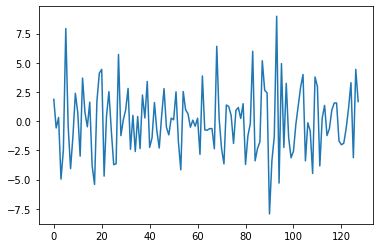

(40, 32, 8064)


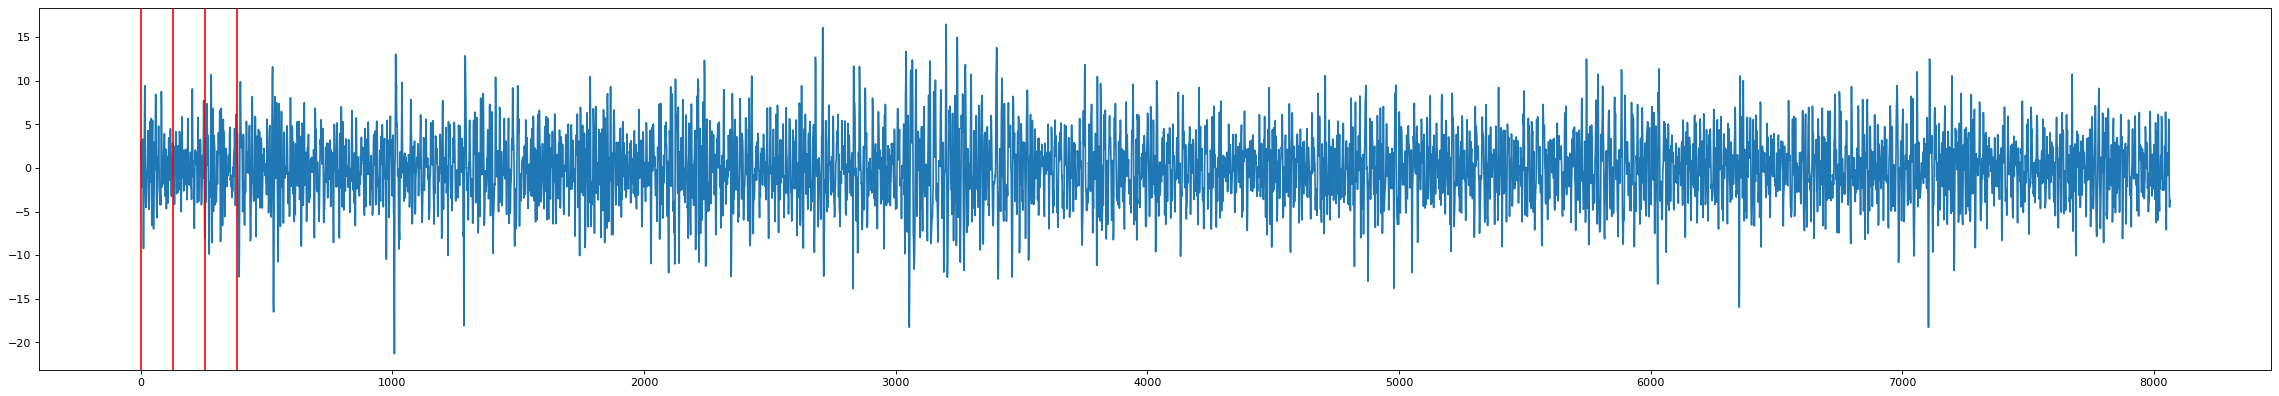

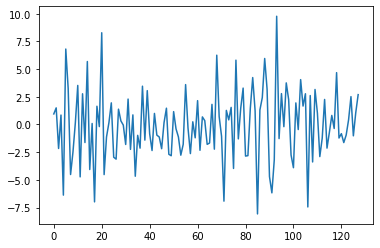

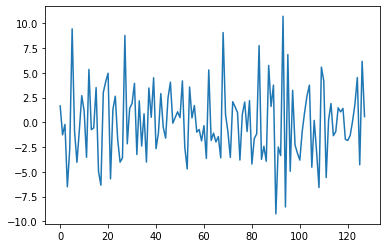

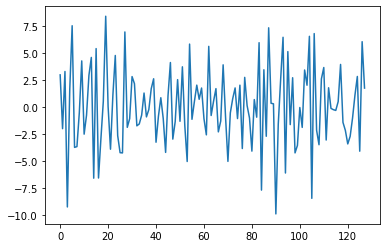

s01.mat:   0%|          | 0/32 [00:01<?, ?it/s]

(40, 32, 8064)


TypeError: exceptions must derive from BaseException

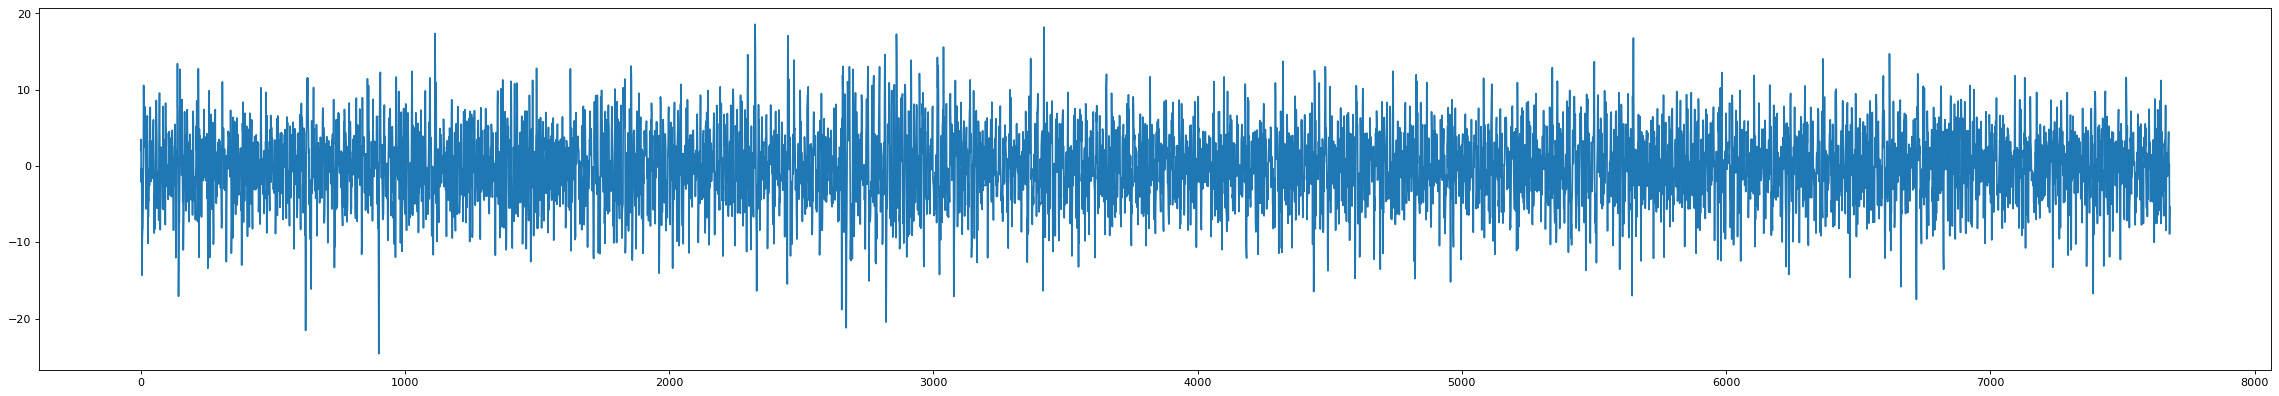

In [133]:
# Constants used to define data paths
ROOT_DIR = './'
RAW_DIR = 'data/matlabPREPROCESSED'
PROCESSED_DIR = 'data/graphProcessedData'

dataset = DEAPDatasetEEGFeatures(root= ROOT_DIR, raw_dir= RAW_DIR, processed_dir= PROCESSED_DIR, feature='psd')
dataset = dataset.shuffle()
dataset[0]

In [5]:
# 880 used for training, 220 validation and 180 testing
# splt_idx = 1100
splt_idx = 35

# 85% used for train/val
train_dataset = dataset[:splt_idx]
test_dataset = dataset[splt_idx:]

train_dataset,test_dataset

(DEAPDatasetEEGFeatures(35), DEAPDatasetEEGFeatures(5))

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [16]:
from torch_geometric.nn import GCNConv
class Model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=2048):
        super(Model, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        
        self.gconv1 = GCNConv(in_channels, hidden_channels*2, aggr='add')
        self.gconv2 = GCNConv(hidden_channels*2, hidden_channels, aggr='add')
#         self.gconv3 = GCNConv(128, self.hidden_channels, aggr='add')
        
        self.conv1 = nn.Conv1d(5*hidden_channels, hidden_channels, 1, stride=1)
        self.conv2 = nn.Conv1d(hidden_channels, hidden_channels//4, 1, stride=1)
        
#         self.lin1 = nn.Linear(59*8,32)
        self.lin1 = nn.Linear(32*hidden_channels//4,1)
#         self.lin3 = nn.Linear(32,1)
        
    def forward(self, batch):
        bs = len(torch.unique(batch.batch))
        x, edge_index, edge_attr = batch.x, batch.edge_index, batch.edge_attr
        

#         x = x.reshape(-1,self.in_channels)
#         print(x.shape)
        x = self.gconv1(x, edge_index,edge_attr)
#         x = torch.tanh(x)
#         x = F.dropout(x, p=0.1, training=self.training)
#         print(x.shape)
#         raise 'err'
        x = self.gconv2(x, edge_index,edge_attr)
#         x = torch.tanh(x)
#         x = self.gconv3(x, edge_index)
#         x = torch.tanh(x)
#         x = x.reshape(bs,-1,32)
        # batch size, graph, electrode, features


        x = rearrange(x, '(b g e) f -> b (g f) e', b=bs, e=32)


        
        x = F.dropout(x, p=0.1, training=self.training)
#         print(x.shape)
#         x = x.reshape(bs,-1,32)



        x = self.conv1(x)
        x = torch.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x)
        x = torch.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = x.reshape(bs,-1)


        x = self.lin1(x)
#         x.relu()
#         x = F.dropout(x, p=0.4, training=self.training)
#         x = self.lin2(x)
#         x.sigmoid()
#         x = F.dropout(x, p=0.2, training=self.training)
#         x = self.lin3(x)
        x = x.view(-1)
        x = x.sigmoid()
#         print(x)
#         x = x*10
        return x

In [19]:
# %%timeit


model = Model(train_dataset[0].x.shape[1])     
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'Model parameter count: {pytorch_total_params}')

model = model.to(device)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=.1, rho=0.9, eps=1e-06, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(),lr=1e-1, weight_decay=1e-3)
# optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-2)
# optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-5)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=5e-4)
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-4, lr_decay=0, weight_decay=1)

# Instantiate optimizer
# scheduler = StepLR(optimizer, step_size=20, gamma=0.7)

# criterion = nn.MSELoss()
criterion = nn.BCELoss()



def train(loader, target = 0):
    model.train()
    losses = []
    right = 0
    tot = 0
    for batch in loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        y = (batch.y[:,target] > 5).float()
        out = model(batch)
        loss = criterion(out,y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        right += torch.eq(out > .5, y > .5).sum().item()
        tot += y.shape[0]
    return np.array(losses).mean(), right/tot

def test(loader,verbose=False, target = 0):
    model.eval()
    losses = []
    right = 0
    tot = 0
    for batch in loader:
        batch = batch.to(device)
        y = (batch.y[:,target] > 5).float()
        out = model(batch)
        if verbose:
            print(out,y)
        loss = criterion(out,y)
        losses.append(loss.item())
        right += torch.eq(out > .5, y > .5).sum().item()
        tot += y.shape[0]
    return np.array(losses).mean(), right/tot

best_val_loss = np.inf
esp = 0
MAX_ESP = 20

BS = 1

k_folds = 5
k_fold_size = len(train_dataset)/k_folds
current_fold = 0 # Ranges from 0 to k_folds-1

target = 1 # Valence-Arousal-Dominance-Liking
for epoch in range(1, 10000):    
    # KFOLD train/val split     
#     if epoch %1 == 0:
#         current_fold = current_fold+1 if current_fold < k_folds-1 else 0
    from_idx, to_idx = int(k_fold_size*current_fold), int(k_fold_size*(current_fold+1))
    kf_val_data = train_dataset[from_idx:to_idx]
    a = train_dataset[:from_idx]
    b = train_dataset[to_idx:]
    kf_train_data = a + b
    train_loader = DataLoader(kf_train_data, batch_size=BS, shuffle=False)
    val_loader = DataLoader(kf_val_data, batch_size=BS)
        
    # Training and validation
    train_loss, train_acc = train(train_loader, target = target)
    val_loss, val_acc = test(val_loader , target = target)
    print(f'Epoch {epoch} - Kfold:{current_fold} ;t loss: {train_loss:.5f} ;t acc: {train_acc:.2f} ;v loss: {val_loss:.5f} ;v acc: {val_acc:.2f}')

    # Early stopping and checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        esp = 0
        torch.save(model.state_dict(),'./best_params') 
    else:
        esp += 1
        if esp >= MAX_ESP:
            break
            
    if epoch % 20 == 0:
        test_loader = DataLoader(test_dataset, batch_size=1)
        loss, acc = test(test_loader, True)
        print(f'Test loss: {loss} ; Test acc: {acc}')
        
#     scheduler.step()


print('Finished training')

Model parameter count: 30679553
Epoch 1 - Kfold:0 ;t loss: 0.88431 ;t acc: 0.32 ;v loss: 0.65372 ;v acc: 0.71
Epoch 2 - Kfold:0 ;t loss: 0.57934 ;t acc: 0.75 ;v loss: 0.64003 ;v acc: 0.71
Epoch 3 - Kfold:0 ;t loss: 0.54299 ;t acc: 0.82 ;v loss: 0.65246 ;v acc: 0.71
Epoch 4 - Kfold:0 ;t loss: 0.49655 ;t acc: 0.82 ;v loss: 0.64738 ;v acc: 0.57
Epoch 5 - Kfold:0 ;t loss: 0.45332 ;t acc: 0.89 ;v loss: 0.65042 ;v acc: 0.57
Epoch 6 - Kfold:0 ;t loss: 0.43654 ;t acc: 0.82 ;v loss: 0.65316 ;v acc: 0.57
Epoch 7 - Kfold:0 ;t loss: 0.41443 ;t acc: 0.89 ;v loss: 0.66046 ;v acc: 0.71
Epoch 8 - Kfold:0 ;t loss: 0.40112 ;t acc: 0.86 ;v loss: 0.65743 ;v acc: 0.71
Epoch 9 - Kfold:0 ;t loss: 0.39033 ;t acc: 0.89 ;v loss: 0.64469 ;v acc: 0.71
Epoch 10 - Kfold:0 ;t loss: 0.38923 ;t acc: 0.93 ;v loss: 0.63683 ;v acc: 0.71
Epoch 11 - Kfold:0 ;t loss: 0.37416 ;t acc: 0.89 ;v loss: 0.66087 ;v acc: 0.71
Epoch 12 - Kfold:0 ;t loss: 0.36105 ;t acc: 0.93 ;v loss: 0.64130 ;v acc: 0.71
Epoch 13 - Kfold:0 ;t loss: 0

In [20]:
model.load_state_dict(torch.load('./best_params'))
test_loader = DataLoader(test_dataset, batch_size=1)
loss, acc = test(train_loader, False,target=target)
print(f'Train loss: {loss} ; Train acc: {acc}')
loss, acc = test(val_loader, False,target=target)

print(f'Val loss: {loss} ; Val acc: {acc}')
loss, acc = test(test_loader, False,target=target)
print(f'Test loss: {loss} ; Test acc: {acc}')

# TODO: scheduler(?) Loss/acc records

Train loss: 0.22529334548328603 ; Train acc: 1.0
Val loss: 0.6171089666230338 ; Val acc: 0.7142857142857143
Test loss: 0.7166383802890778 ; Test acc: 0.4
